In [1]:
import pandas_datareader as pdr
from utils import *
import os
import time
import numpy as np
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import BatchNormalization,Bidirectional,TimeDistributed,Dense,Input,Conv2D,MaxPool1D,Activation,Dropout,Flatten,Conv1D,concatenate,Embedding,LSTM
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import tensorflow as tf
from sklearn.externals import joblib 
from tensorflow.keras.initializers import he_normal,glorot_normal,he_uniform
from tensorflow.keras.utils import to_categorical

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
related_companies = ['AMD','INTC','NVDA','MSFT','QCOM','TSM','SPY']

In [3]:
for stock_name in related_companies:
  if not os.path.isfile("Data/"+ stock_name + '.csv'):
    df = pdr.get_data_tiingo(symbols=[stock_name],start='1/1/2010',end = '05/31/2020', api_key='bc41cd89fc117b78bbde26797c2f1b72b7aa83c2')
    df.to_csv( "Data/"+ stock_name + '.csv')
    df = pd.read_csv("Data/"+ stock_name + '.csv')
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].apply(lambda x: x.date())
    df.to_csv( "Data/"+ stock_name + '.csv')
  elif stock_name=='AMD':
    amd_df = pd.read_csv('Data/AMD.csv')
  else:
    pass

In [4]:
amd_df = pd.read_csv('Data/AMD.csv',index_col=0)

In [5]:
amd_df = amd_df[['date','close']]

In [6]:
train_seq = int(len(amd_df['date'])*.85)

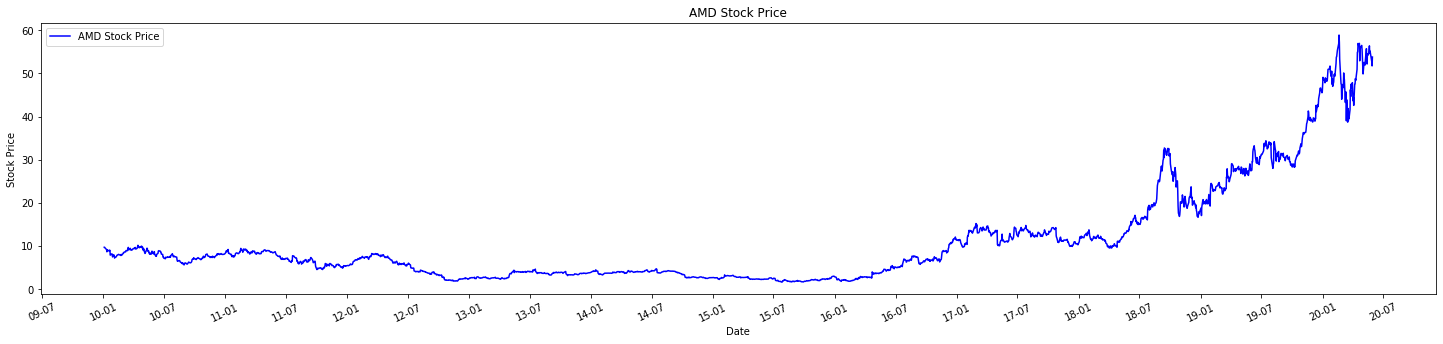

In [15]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
amd_df['date'] = pd.to_datetime(amd_df['date'])
ax.plot(amd_df['date'],amd_df['close'],color='b',label = 'AMD Stock Price')
ax.set_title('AMD Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

months = mdates.MonthLocator(interval=6)
months_fmt = mdates.DateFormatter('%y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
plt.xticks( rotation=25 )
ax.legend()
plt.show()

Technical Indicators

In [17]:
def technical_indicators(df):
  # Moving Average
  df['week_moving_avg'] = df['close'].rolling(window=7,min_periods=1).mean()
  df['21d_moving_avg'] = df['close'].rolling(window=21,min_periods=1).mean()

  # MACD
  df['12_ema'] = df[['close']].ewm(span=12).mean()
  df['26_ema'] = df[['close']].ewm(span=26).mean()
  df['macd'] = df['12_ema'] - df['26_ema']
  
  # Bollinger Bands
  df['20_day_std'] = df['close'].rolling(window=20,min_periods=0).std()
  df['upper_band'] = df['21d_moving_avg'] + (df['20_day_std']*2)
  df['lower_band'] = df['21d_moving_avg'] - (df['20_day_std']*2)

  return df

***Moving Average Convergence And Divergence:***

MACD:https://www.investopedia.com/terms/m/macd.asp

MACD = 12 day Exponential MA - 26 day Exponential MA 

***Bollinger Bands***

Its a band that is mean + 2 std and mean - 2 std. The idea is that bollinger bands cover 95% of the values from the actual mean value i.e moving average. Genrally we consider 20 day moving average.

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands

In [18]:
amd_df = technical_indicators(amd_df)

In [19]:
trend = []
for index,closing_price in enumerate(amd_df['close']):
    
    if index==0:
        trend.append(0)
    else:
        if closing_price-amd_df['close'][index-1]<0:
            trend.append(0)
        else:
            trend.append(1)
amd_df['trend'] = trend    

Plot of technical indicators

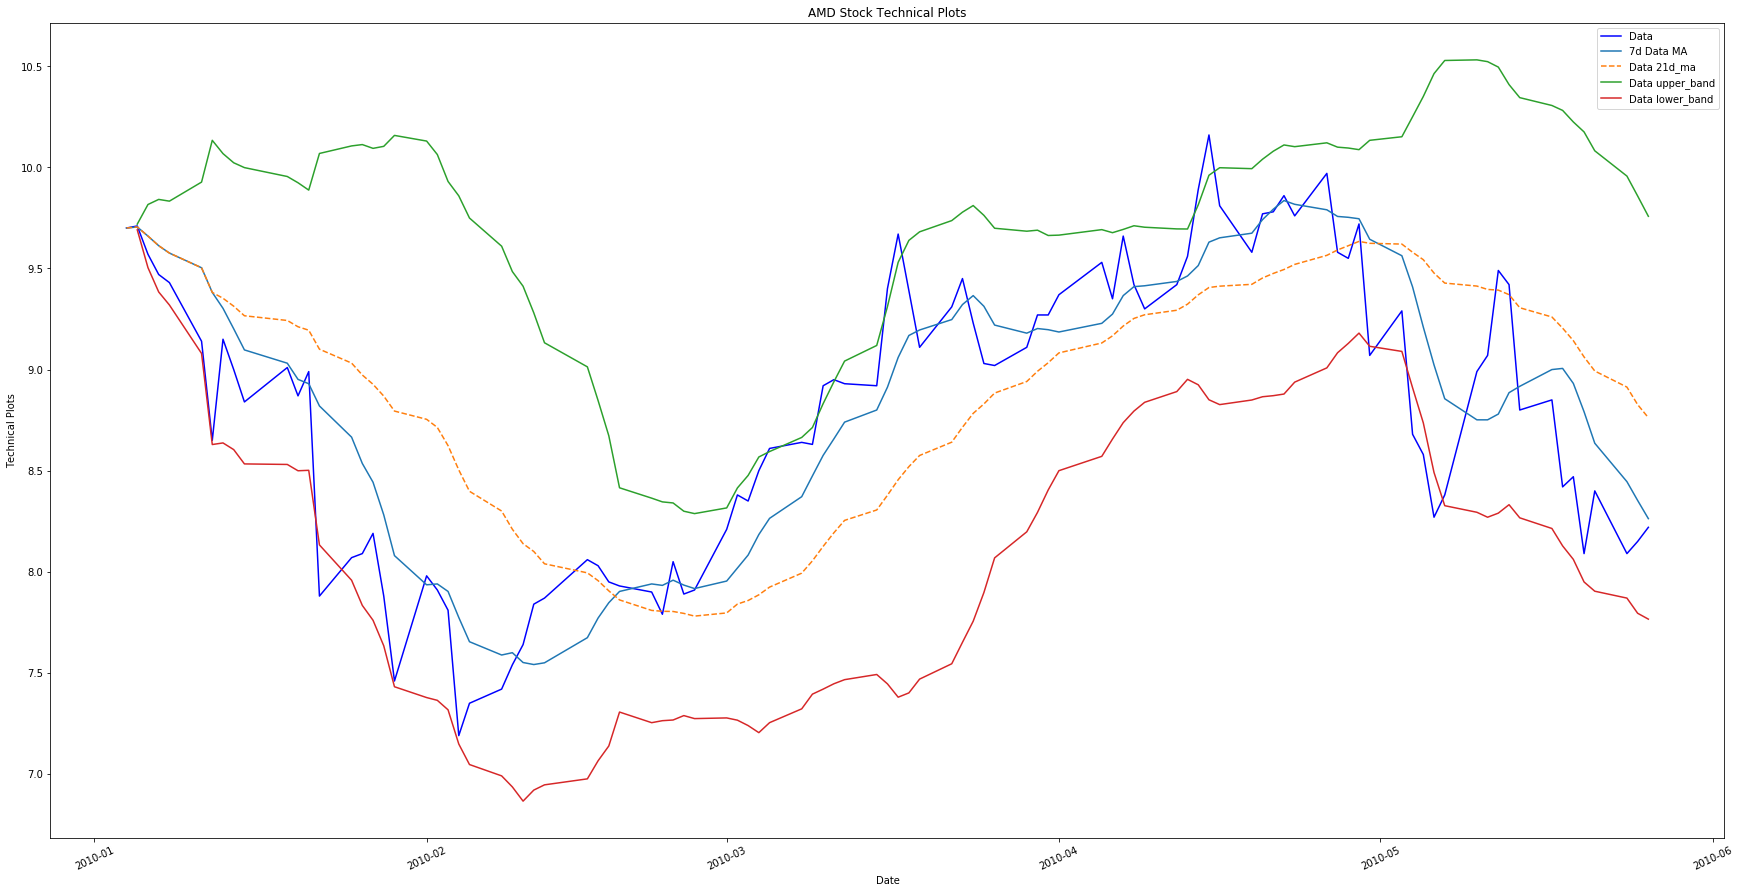

In [20]:
plt.figure(figsize=(30,15))

plt.plot(amd_df['date'][:100],amd_df['close'][:100],color='b',label = 'Data')

plt.plot(amd_df['date'][:100],amd_df['week_moving_avg'][:100],label = '7d Data MA',linestyle='-')

plt.plot(amd_df['date'][:100],amd_df['21d_moving_avg'][:100],label = 'Data 21d_ma',linestyle='--')

plt.plot(amd_df['date'][:100],amd_df['upper_band'][:100],label = 'Data upper_band')

plt.plot(amd_df['date'][:100],amd_df['lower_band'][:100],label = 'Data lower_band')

months = mdates.MonthLocator(interval=6)
months_fmt = mdates.DateFormatter('%y-%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
plt.xticks( rotation=25 )

plt.title('AMD Stock Technical Plots')
plt.xlabel('Date')
plt.ylabel('Technical Plots')
plt.legend()

plt.show()

In [21]:
close_fft = np.fft.fft(np.asarray(amd_df['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

C:\Users\harsh\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\harsh\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\harsh\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\harsh\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


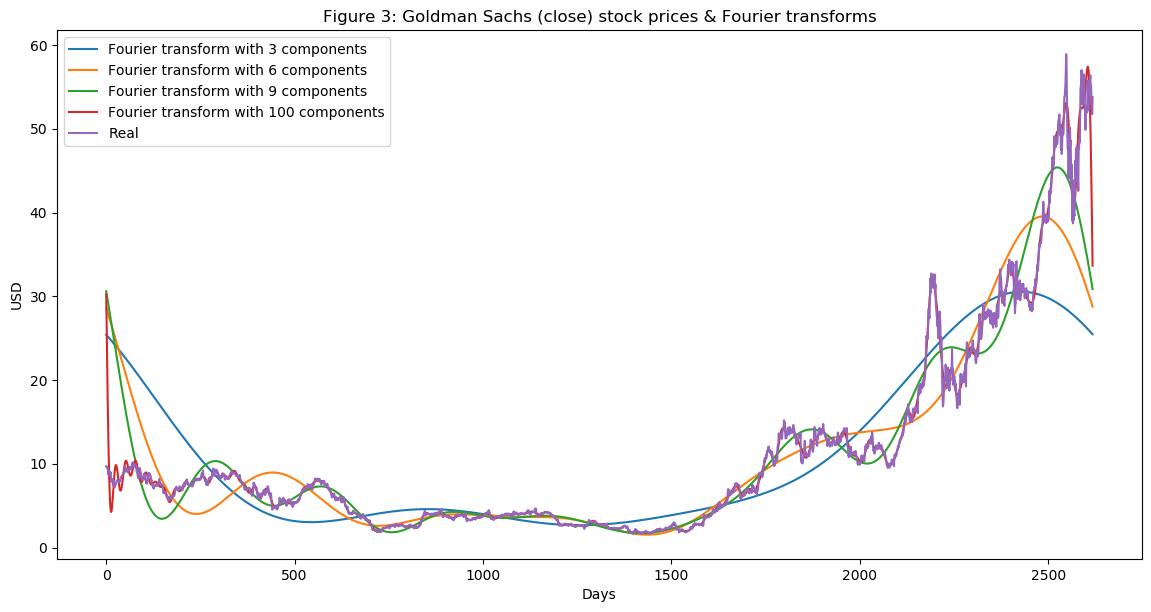

In [22]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(amd_df['close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [14]:
fft_df

,fft,absolute,angle
0,33045.448900+0.000000j,33045.448900,7.310675e-18
1,16047.746726+9809.423647j,18808.374924,5.486613e-01
2,5503.855804+8009.270392j,9718.067757,9.687225e-01
3,4135.346127+5919.672516j,7221.053268,9.610261e-01
4,1555.842840+6774.784589j,6951.140422,1.345058e+00
...,...,...,...
2678,1637.214071-3870.262163j,4202.308785,-1.170600e+00
2679,1555.842840-6774.784589j,6951.140422,-1.345058e+00
2680,4135.346127-5919.672516j,7221.053268,-9.610261e-01
2681,5503.855804-8009.270392j,9718.067757,-9.687225e-01


In [15]:
amd_df_final = pd.concat([amd_df,fft_df],axis=1)

In [16]:
amd_df_final = amd_df_final.drop(['date'],axis=1)
amd_df_final = amd_df_final.drop(['fft'],axis=1)
for others in related_companies[1:]:
    temp_df = pd.read_csv("Data/"+ others + '.csv',index_col=0)
    amd_df_final[others] = temp_df['close']

In [17]:
amd_df_final = amd_df_final.dropna()


In [18]:
amd_df_final

,close,week_moving_avg,21d_moving_avg,12_ema,26_ema,macd,20_day_std,upper_band,lower_band,trend,absolute,angle,INTC,NVDA,MSFT,QCOM,TSM,SPY
1,9.71,9.705000,9.705000,9.705417,9.705192,0.000224,0.007071,9.719142,9.690858,1,18808.374924,0.548661,20.87,18.76,30.960,48.07,11.53,113.63
2,9.57,9.660000,9.660000,9.652564,9.656619,-0.004056,0.078102,9.816205,9.503795,0,9718.067757,0.968722,20.80,18.88,30.770,47.60,11.49,113.71
3,9.47,9.612500,9.612500,9.594935,9.604449,-0.009513,0.114419,9.841338,9.383662,0,7221.053268,0.961026,20.60,18.51,30.452,48.98,11.11,114.19
4,9.43,9.576000,9.576000,9.550123,9.563993,-0.013870,0.128374,9.832749,9.319251,0,6951.140422,1.345058,20.83,18.55,30.660,49.47,11.10,114.57
5,9.14,9.503333,9.503333,9.450442,9.479071,-0.028629,0.211818,9.926968,9.079698,0,4202.308785,1.170600,20.95,18.29,30.270,49.29,11.04,114.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,83.08,82.304286,80.360952,81.438916,76.468095,4.970821,4.334785,89.030523,71.691382,0,4202.308785,-1.170600,49.14,508.81,213.690,115.91,78.90,342.92
2679,86.35,83.025714,81.188571,82.194468,77.200088,4.994380,3.173847,87.536265,74.840878,1,6951.140422,-1.345058,49.43,510.00,216.470,115.95,80.04,344.12
2680,86.02,83.540000,82.065238,82.783011,77.853415,4.929596,2.994084,88.053407,76.077069,0,7221.053268,-0.961026,49.55,510.92,221.150,116.04,81.75,347.57
2681,83.80,83.845714,82.432381,82.939471,78.293903,4.645568,2.842177,88.116736,76.748026,0,9718.067757,-0.968722,49.40,505.13,226.580,116.02,80.60,348.33


In [19]:
amd_df_final = amd_df_final[['week_moving_avg','21d_moving_avg','12_ema','26_ema','macd','20_day_std','upper_band','lower_band','absolute','angle','INTC','NVDA','MSFT','QCOM','TSM','SPY','close']]

In [20]:
amd_df_final

,week_moving_avg,21d_moving_avg,12_ema,26_ema,macd,20_day_std,upper_band,lower_band,absolute,angle,INTC,NVDA,MSFT,QCOM,TSM,SPY,close
1,9.705000,9.705000,9.705417,9.705192,0.000224,0.007071,9.719142,9.690858,18808.374924,0.548661,20.87,18.76,30.960,48.07,11.53,113.63,9.71
2,9.660000,9.660000,9.652564,9.656619,-0.004056,0.078102,9.816205,9.503795,9718.067757,0.968722,20.80,18.88,30.770,47.60,11.49,113.71,9.57
3,9.612500,9.612500,9.594935,9.604449,-0.009513,0.114419,9.841338,9.383662,7221.053268,0.961026,20.60,18.51,30.452,48.98,11.11,114.19,9.47
4,9.576000,9.576000,9.550123,9.563993,-0.013870,0.128374,9.832749,9.319251,6951.140422,1.345058,20.83,18.55,30.660,49.47,11.10,114.57,9.43
5,9.503333,9.503333,9.450442,9.479071,-0.028629,0.211818,9.926968,9.079698,4202.308785,1.170600,20.95,18.29,30.270,49.29,11.04,114.73,9.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,82.304286,80.360952,81.438916,76.468095,4.970821,4.334785,89.030523,71.691382,4202.308785,-1.170600,49.14,508.81,213.690,115.91,78.90,342.92,83.08
2679,83.025714,81.188571,82.194468,77.200088,4.994380,3.173847,87.536265,74.840878,6951.140422,-1.345058,49.43,510.00,216.470,115.95,80.04,344.12,86.35
2680,83.540000,82.065238,82.783011,77.853415,4.929596,2.994084,88.053407,76.077069,7221.053268,-0.961026,49.55,510.92,221.150,116.04,81.75,347.57,86.02
2681,83.845714,82.432381,82.939471,78.293903,4.645568,2.842177,88.116736,76.748026,9718.067757,-0.968722,49.40,505.13,226.580,116.02,80.60,348.33,83.80


In [21]:
train_data =  pd.DataFrame(amd_df_final.values[:train_seq,:],columns=['week_moving_avg','21d_moving_avg','12_ema','26_ema','macd','20_day_std','upper_band','lower_band','absolute','angle','INTC','NVDA','MSFT','QCOM','TSM','SPY','close'])
test_data =  pd.DataFrame(amd_df_final.values[train_seq:,:],columns=['week_moving_avg','21d_moving_avg','12_ema','26_ema','macd','20_day_std','upper_band','lower_band','absolute','angle','INTC','NVDA','MSFT','QCOM','TSM','SPY','close'])

In [22]:
scale = MinMaxScaler()
train_data = scale.fit_transform(train_data)
train_data =  pd.DataFrame(train_data,columns=['week_moving_avg','21d_moving_avg','12_ema',\
                                                                      '26_ema','macd','20_day_std','upper_band','lower_band',\
                                                                      'absolute','angle','INTC','NVDA','MSFT',\
                                                                      'QCOM','TSM','SPY','close'])


In [23]:
joblib.dump(scale,'min_max_scaler.pkl')

['min_max_scaler.pkl']

In [24]:
test_data = scale.transform(test_data)
test_data =  pd.DataFrame(test_data,columns=['week_moving_avg','21d_moving_avg','12_ema',\
                                                                      '26_ema','macd','20_day_std','upper_band','lower_band',\
                                                                      'absolute','angle','INTC','NVDA','MSFT',\
                                                                      'QCOM','TSM','SPY','close'])


In [25]:
train_data

,week_moving_avg,21d_moving_avg,12_ema,26_ema,macd,20_day_std,upper_band,lower_band,absolute,angle,INTC,NVDA,MSFT,QCOM,TSM,SPY,close
0,0.264944,0.272858,0.268849,0.289298,0.455540,0.000000,0.234357,0.316448,1.000000,0.587358,0.081314,0.035217,0.085853,0.324537,0.057599,0.059724,0.260129
1,0.263454,0.271306,0.267064,0.287523,0.454811,0.017735,0.237268,0.309256,0.516624,0.654240,0.079538,0.035645,0.083801,0.315068,0.056517,0.060142,0.255627
2,0.261882,0.269668,0.265118,0.285617,0.453882,0.026803,0.238022,0.304638,0.383845,0.653015,0.074464,0.034325,0.080367,0.342869,0.046241,0.062650,0.252412
3,0.260673,0.268409,0.263605,0.284139,0.453141,0.030288,0.237764,0.302162,0.369493,0.714160,0.080299,0.034468,0.082613,0.352740,0.045971,0.064636,0.251125
4,0.258268,0.265904,0.260238,0.281037,0.450628,0.051122,0.240590,0.292953,0.223324,0.686383,0.083344,0.033541,0.078402,0.349114,0.044348,0.065472,0.241801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.612220,0.593566,0.613944,0.655027,0.490832,0.349669,0.597286,0.566303,0.005339,0.114882,0.799822,0.527841,0.914687,0.469581,0.742023,0.858292,0.615756
2276,0.612314,0.596194,0.613096,0.655147,0.485998,0.345515,0.598573,0.570511,0.005073,0.124560,0.776481,0.498748,0.892765,0.449839,0.729313,0.839482,0.583280
2277,0.610092,0.599248,0.612586,0.655366,0.482407,0.321784,0.595528,0.581224,0.004952,0.135450,0.768109,0.500602,0.903888,0.399073,0.732558,0.842356,0.584566
2278,0.613024,0.605685,0.617610,0.658411,0.493543,0.293408,0.594310,0.597138,0.005166,0.159565,0.814284,0.531085,0.898380,0.379734,0.763656,0.843087,0.618328


In [26]:
final_data_frame = pd.concat([train_data,test_data],axis=0)

In [27]:
final_data_frame.shape

(2682, 17)

In [28]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [29]:
time_series_data = series_to_supervised(final_data_frame, 20, 50)

In [30]:
time_series_data

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var7(t-20),var8(t-20),var9(t-20),var10(t-20),...,var8(t+49),var9(t+49),var10(t+49),var11(t+49),var12(t+49),var13(t+49),var14(t+49),var15(t+49),var16(t+49),var17(t+49)
20,0.264944,0.272858,0.268849,0.289298,0.455540,0.000000,0.234357,0.316448,1.000000,0.587358,...,0.284145,0.038004,0.823335,0.166333,0.032543,0.084881,0.216358,0.046782,0.099749,0.274598
21,0.263454,0.271306,0.267064,0.287523,0.454811,0.017735,0.237268,0.309256,0.516624,0.654240,...,0.283227,0.033642,0.854397,0.158696,0.029156,0.082721,0.217164,0.039210,0.089665,0.263344
22,0.261882,0.269668,0.265118,0.285617,0.453882,0.026803,0.238022,0.304638,0.383845,0.653015,...,0.284102,0.028997,0.841721,0.160726,0.028870,0.086706,0.217365,0.038940,0.092016,0.255949
23,0.260673,0.268409,0.263605,0.284139,0.453141,0.030288,0.237764,0.302162,0.369493,0.714160,...,0.284723,0.026961,0.838011,0.163770,0.029084,0.090173,0.228243,0.040562,0.097607,0.262058
24,0.258268,0.265904,0.260238,0.281037,0.450628,0.051122,0.240590,0.292953,0.223324,0.686383,...,0.284926,0.021901,0.861100,0.155651,0.027516,0.089870,0.214948,0.038940,0.096457,0.262379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1.719569,1.801734,1.748335,1.857157,0.607270,0.478643,1.679037,1.873473,0.021901,0.138900,...,2.699947,0.223324,0.313617,0.798554,1.782416,2.059179,1.691176,1.879394,1.257812,2.619293
349,1.732053,1.798433,1.753940,1.862489,0.610676,0.446234,1.668380,1.879773,0.026961,0.161989,...,2.821024,0.369493,0.285840,0.805911,1.786658,2.089201,1.691982,1.910222,1.264082,2.724437
350,1.742836,1.795970,1.763256,1.869809,0.623524,0.452489,1.667741,1.875101,0.028997,0.158279,...,2.868547,0.383845,0.346985,0.808956,1.789939,2.139741,1.693795,1.956463,1.282109,2.713826
351,1.745909,1.801668,1.775919,1.879075,0.644167,0.459970,1.674494,1.879150,0.033642,0.145603,...,2.894341,0.516624,0.345760,0.805150,1.769295,2.198380,1.693392,1.925365,1.286080,2.642444


In [31]:
train_data = time_series_data.values[:train_seq,:]
test_data = time_series_data.values[train_seq:,:]


In [32]:
train_data.shape

(2280, 1190)

In [33]:
test_data.shape

(333, 1190)

In [38]:
past_time = 70
no_of_features = 17
observation_set = past_time * no_of_features

In [39]:
train_X, train_y = train_data[:, :observation_set], train_data[:, -1]
test_X, test_y = test_data[:, :observation_set], test_data[:, -1]

In [40]:
test_X.shape

(333, 1190)

In [41]:
train_X = train_X.reshape(train_X.shape[0], past_time,no_of_features)
test_X = test_X.reshape(test_X.shape[0], past_time,no_of_features)

In [42]:
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

In [43]:
model.fit(x=train_X,y=train_y,epochs=100,validation_data=(test_X,test_y))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
70/72 [============================>.] - ETA: 0s - loss: 0.0444 - mse: 0.0090WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023BA1A20AF8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

In [44]:
model.save('time_series_model.h5')

Test Details

In [45]:
yhat = model.predict(test_X)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [46]:
yhat.shape

(333, 1)

In [47]:
test_X = test_X.reshape(test_X.shape[0],observation_set)

In [48]:
result = np.concatenate([test_X[:,-(no_of_features-1):],yhat],axis=1)

result = scale.inverse_transform(result)

In [49]:
result_pred = result[:,-1]

In [50]:
test_y = test_y.reshape((len(test_y), 1))

In [51]:
test_X.shape

(333, 1190)

In [52]:
result_real = np.concatenate([test_X[:,-(no_of_features-1):],test_y],axis=1)
result_real = scale.inverse_transform(result_real)

In [53]:
result_real = result_real[:,-1]

In [54]:
rmse = np.sqrt(mean_squared_error(result_real, result_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.479


In [55]:
from sklearn.metrics import r2_score

rmse = r2_score(result_real, result_pred)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.999


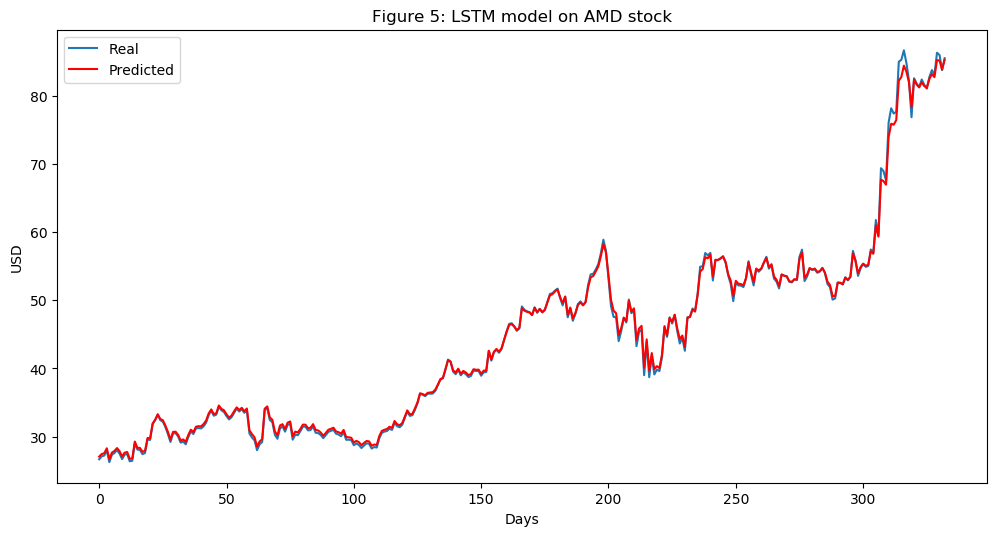

In [56]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(result_real, label='Real')
plt.plot(result_pred, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: LSTM model on AMD stock')
plt.legend()
plt.show()

Train Details

In [57]:
yhat_train = model.predict(train_X)

In [58]:
train_X = train_X.reshape(train_X.shape[0],observation_set)

In [59]:
result_train = np.concatenate([train_X[:,-(no_of_features-1):],yhat_train],axis=1)

result_train = scale.inverse_transform(result_train)

In [60]:
result_train_pred = result_train[:,-1]

In [61]:
train_y = train_y.reshape((len(train_y), 1))

In [62]:
result_train_real = np.concatenate([train_X[:,-(no_of_features-1):],train_y],axis=1)
result_train_real = scale.inverse_transform(result_train_real)

In [63]:
result_train_real = result_train_real[:,-1]

In [64]:
rmse = np.sqrt(mean_squared_error(result_train_real, result_train_pred))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 0.115


In [65]:
from sklearn.metrics import r2_score

rmse = r2_score(result_train_real, result_train_pred)
print('Train RMSE: %.3f' % rmse)

Train RMSE: 1.000


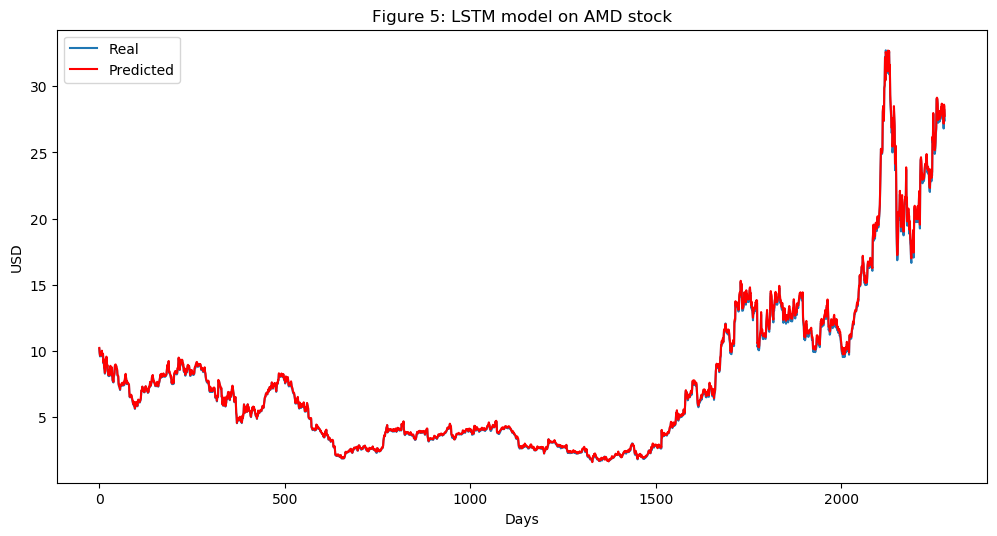

In [66]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(result_train_real, label='Real')
plt.plot(result_train_pred, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: LSTM model on AMD stock')
plt.legend()
plt.show()